In [1]:
import pandas as pd

# Dependency parsing and coreference resolution 
import spacy

# Sentiment analysis 
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# csv parsing 
import csv

# df and math operations 
import numpy as np


/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manuelnunezmartinez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/manuelnunezmartinez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


The Named Entity Recognition Model will employ sentiment analysis to classify the sentiment expressed toward each entity mentioned in an article. It will be built the following way: 

MODEL IMPLEMENTATION

1. All the preprocessing steps mentioned in the preProcessing notebook will be applied to the articles contained in a dataframe. However, stop words will not be removed and llematization will not be applied,
as this model will be built using dependncy parsing and the removal of stop words can decontexualize the data. The resulting object will be a list of sentences.

2. A dictionary will be initialized of type {'Noun/entity': 'Adjectives describing it'}

3.For each sentence a dependency tree will be built. It will be parsed and every time a noun is encountered, all adjectives stemming from it will be added to the dictionary entry for that particular noun.
***NOTE: The parsing will also consider named entitities in addition to nouns.These will have to be treated slighly differently*** 

4.Once all sentences have been parsed and each noun has its describing adjectives, each list of adjectives will be llematized. 

5.All nouns encountered (dictionary keys) will also be lemmatized. If two of the same keys result after lemmatization, their corrrsponidng adjectives will be combined. 
***NOTE: A unique list of adjectives for each noun will not be kept in order to consider the weight of different sentiment expressed***

6.With the final dictionary ready for use, each adjective will be assigned a valence score using the TextBlob library and an average valence score will be assigned to each noun/Entity. 

7. This final dictionary of form {'Noun/Named Entity' : 'valence score' } will be built for each of the three data frames being explored. 

8. With all three dictionaries completed, all nouns/named entities found will be assigned a unique numerical identifier. 

9. Each dictionary will then take the form {'identifier' : 'valence score' } where each dictionary covers every identifier and has a valence score of 0 if the noun/entity isnt present within its corresponding data frame. 

10. Ultimatley we will have three vectors of N dimension where N is the number of nouns/entities found throughout all articles. 


CLASSIFICATION: 

1. Steps 1 - 5 will be applied to an article we want to classify

2. Once an average valence score is found for each noun/entity, an empty vector of length N will be created and the valence score for each noun/entity's identifier will be inputted. 

3. The cosine distance beetween all three vectors created in model implementation and the articles vector will be taken. 

4. Whichever vector is it is closest too will be the articles corresponding classification. 

In [2]:
'''
SIMPLE EXAMPLE: 

Left Bias Dictionary: {'Trump':-0.70, 'IRA': 0.50, 'Israel': 0.10, 'Immigrant': 0.30}
Right Bias Dictionary: {'Trump':0.80, 'IRA': -0.10, 'Israel': 0.80, 'Vaccine': -0.50}
Moderate Bias Dictionary: {'Trump':-0.20, 'IRA': 0.10, 'Israel': 0.30, 'China': -0.1}

Identifier Mapping: { 'Trump': 0, 'IRA': 1, 'Israel': 2, 'Immigrant': 3, 'Vaccine': 4, 'China': 5}

Resulting Vectors: 
'''
Left = [-0.70, 0.50, 0.10, 0.30, 0.0, 0.0]
Right = [0.80, -0.10, 0.80, 0.0, -0.50, 0.0]
Moderate = [-0.20, 0.10, 0.30, 0.0, 0.0, -0.1]

'''
Article Input: 
Dictionary: {'Trump':-0.30, 'Immigrant': 0.10}
'''
vector =  [-0.30, 0.0, 0.0, 0.10, 0.0, 0.0]

from scipy.spatial.distance import cosine

print("cosine distance with left: ", cosine(Left, vector))
print("cosine distance with right: ", cosine(Right, vector))
print("cosine distance with Moderate: ", cosine(Moderate, vector))

# We seen how the article lies closest to a left bias. 

cosine distance with left:  0.17192132878917488
cosine distance with right:  1.6115766297251506
cosine distance with Moderate:  0.5101020514433644


# The functions below are used for the recognition and quantifiaction of sentiment

In [3]:

def find_distances(sentence, from_pos, to_pos):   
    sent_dic = {}
    # Create memoization array 
    mem = [(-1, "")] * (len(sentence) + 1)

    #mark closest predecessors 
    mark_down(sentence.root, to_pos, mem)
    
    #consider succesors and finalize dictionary 
    for token in sentence:
        if token.pos_ in from_pos:
            # cretae dictionary entry for token
            if token.text not in sent_dic:
                sent_dic[token.text] = []
            
            if token != sentence.root:
                mark_up(token, mem, token.head, 1)
            
            sent_dic[token.text].append(mem[token.i][1])
            

    return sent_dic


# check parent node recursivley as long as current distance from a noun isnt surpassed 
def mark_up(ref, mem, token, dist):
    closest = mem[token.i][0]
    if closest != -1 and (closest + dist < mem[ref.i][0] or mem[ref.i][0] == -1):
        mem[ref.i] = (mem[token.i][0] + dist, mem[token.i][1])
    
    if token.dep_ != "ROOT":
        mark_up(ref, mem, token.head, dist + 1)


# mark all entires in memoization array with closest noun succesor 
def mark_down(token, to_pos, mem):
    if token.pos_ in to_pos:
        mem[token.i] = (0, token.text)

    dist = (10000, "")
    for child in token.children:
        mark_down(child, to_pos, mem)
        closest = mem[child.i][0]
        if closest != -1 and closest < dist[0]:
            dist = (closest, mem[child.i][1])
        
    if dist[0] != 10000 and token.pos_ not in to_pos:
        update = (dist[0] + 1, dist[1])
        mem[token.i] = update

def format_relations(relations):
    sent_dic = {}

    for key in relations:
        for ref in relations[key]:
            if ref not in sent_dic:
                sent_dic[ref] = [key]
            else:
                sent_dic[ref].append(key)

    for key, value in sent_dic.items():
        sent_dic[key] = sorted(value)

    return sent_dic


def vectorize_dic(sent_dic):
    for key in sent_dic:
        sentiment = 0
        for ref in sent_dic[key]:
            ref_blob = TextBlob(ref)
            ref_sentiment = ref_blob.sentiment.polarity
            sentiment += ref_sentiment
        sent_dic[key] = sentiment
    return sent_dic

# def retokenize_entities(doc):

#     # Step 1: Identify Multi-Word Named Entities
#     multi_word_entities = []
#     for ent in doc.ents:
#         if len(ent) > 1:
#             multi_word_entities.append(ent)

#     # Step 2: Merge Tokens
#     for ent in multi_word_entities:
#         with doc.retokenize() as retokenizer:
#             start = ent.start
#             end = ent.end
#             retokenizer.merge(doc[start:end])

def retokenize_entities(doc):
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            # Only merge entities with more than one token
            if len(ent) > 1:
                # Merge entities
                retokenizer.merge(doc[ent.start:ent.end])


We begin building the model by loading in the csvs of the cleaned data sets. 

In [4]:
# read in df and make sure there are no empty entires 
center = pd.read_csv("coref_data/NER_center.csv")
left = pd.read_csv("coref_data/NER_left.csv")
right = pd.read_csv("coref_data/NER_right.csv")

center = center[center['summary'].apply(type) == str]
left = left[left['summary'].apply(type) == str]
right = right[right['summary'].apply(type) == str]

In [5]:
center.columns
right.columns
left.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'summary', 'class'], dtype='object')

In [6]:
# create training and testing data frames with an 80/20 split
center_drop = np.arange(5, len(center), 6)
center_test = center.iloc[center_drop].copy()
center_train = center.drop(center.index[center_drop])
print(center_train.shape)
print(center_test.shape)

right_drop = np.arange(4, len(right), 5)
right_test = right.iloc[right_drop].copy()
right_train = right.drop(right.index[right_drop])
print(right_train.shape)
print(right_test.shape)

left_drop = np.arange(4, len(left), 5)
left_test = left.iloc[left_drop].copy()
left_train = left.drop(left.index[left_drop])
print(left_train.shape)
print(left_test.shape)

(5947, 4)
(1189, 4)
(4735, 4)
(1183, 4)
(8475, 4)
(2118, 4)


In [4]:

def vectorize_sentence(sent):
    
    relations = find_distances(sent, ['ADJ', 'ADV', 'VERB'],['NOUN'] )
    relation_dic = format_relations(relations)
    vector_dic = vectorize_dic(relation_dic)
    
    return vector_dic


def merge_dics_add(add, addOnTo):
    for key, value in add.items():
        if key in addOnTo:
            # If the key is in both, add the values
            addOnTo[key] += value
        else:
            # If the key is unique to dict2, add it to the merged dictionary
            addOnTo[key] = value

def merge_dics_append(add, addOnTo):
    for key, value in add.items():
        if key in addOnTo:
            # If the key is in both, append
            addOnTo[key].append(value)
        else:
            # If the key is unique to dict2, add it to the merged dictionary
            addOnTo[key] = [value]

def avg_dic(valence_dic):
    for key, value_list in valence_dic.items():
        if value_list:  # Ensure the list is not empty to avoid division by zero
            average = sum(value_list) / len(value_list)
            valence_dic[key] = average
        else:
            valence_dic[key] = 0
        


The code bwlos is used to create three dictionary for each political leaning. 

In [22]:
# training_data = [(center_train, 'center_sent.csv'), (right_train, 'right_sent.csv'), (left_train, 'left_sent.csv')]
training_data = [(left_train, 'left_sent.csv')]
nlp = spacy.load("en_core_web_sm")

for df in training_data:
        sentiment_dic = {}
        print("Processing Category: ", df[1])
        print("Number of Articles to process: ", df[0].shape[0])
        for index, row in df[0].iterrows():
                print(index)
                article  = row['summary']
                doc_article = nlp(article)
                article_dic = {}
                for sent in doc_article.sents:
                        doc = nlp(sent.text)
                        retokenize_entities(doc)
                        valence_dic = {}

                        stop = False
                        for sentence in doc.sents:
                                if not stop:
                                        valence_dic = vectorize_sentence(sentence)
                                        stop = True
                        merge_dics_append(valence_dic, article_dic)
                avg_dic(article_dic)
                merge_dics_add(article_dic, sentiment_dic)
        
        # Convert sentiment_dic to a DataFrame
        sentiment_df = pd.DataFrame(list(sentiment_dic.items()), columns=['Noun', 'Sentiment'])
        # Save to CSV
        sentiment_df.to_csv('sentiment_dicts/' + df[1], index=False)
                        


print("Done With Sentiment Dictionary Assembly.")


Processing Category:  left_sent.csv
Number of Articles to process:  8475
0
1
2
3
5
6
7
8
10
11
12
13
15
16
17
18
20
21
22
23
25
26
27
28
30
31
32
33
35
36
37
38
40
41
42
43
45
46
47
48
50
51
52
53
55
56
57
58
60
61
62
63
65
66
67
68
70
71
72
73
75
76
77
78
80
81
82
83
85
86
87
88
90
91
92
93
95
96
97
98
100
101
102
103
105
106
107
108
110
111
112
113
115
116
117
118
120
121
122
123
125
126
127
128
130
131
132
133
135
136
137
138
140
141
142
143
145
146
147
148
150
151
152
153
155
156
157
158
160
161
162
163
165
166
167
168
170
171
172
173
175
176
177
178
180
181
182
183
185
186
187
188
190
191
192
193
195
196
197
198
200
201
202
203
205
206
207
208
210
211
212
213
215
216
217
218
220
221
222
223
225
226
227
228
230
231
232
233
235
236
237
238
240
241
242
243
245
246
247
248
250
251
252
253
255
256
257
258
260
261
262
263
265
266
267
268
270
271
272
273
275
276
277
278
280
281
282
283
285
286
287
288
290
291
292
293
295
296
297
298
300
301
302
303
305
306
307
308
310
311
312
313
315
316

The code below takes the three dictionaries created above and turns them into vectors mapped within the same space 

In [5]:
center_bias_dict = pd.read_csv('sentiment_dicts/center_sent.csv') 
left_bias_dict = pd.read_csv('sentiment_dicts/left_sent.csv') 
right_bias_dict = pd.read_csv('sentiment_dicts/right_sent.csv') 

In [6]:
print(center_bias_dict.shape)
print(left_bias_dict.shape)
print(right_bias_dict.shape)

(16082, 2)
(20717, 2)
(26055, 2)


In [7]:
center_bias_dict = center_bias_dict[center_bias_dict['Sentiment'] != 0.0]
left_bias_dict = left_bias_dict[left_bias_dict['Sentiment'] != 0.0]
right_bias_dict = right_bias_dict[right_bias_dict['Sentiment'] != 0.0]

In [8]:
print(center_bias_dict.shape)
print(left_bias_dict.shape)
print(right_bias_dict.shape)

(7339, 2)
(10191, 2)
(13219, 2)


In [9]:
# Concatenate 'Noun' columns from all DataFrames
all_nouns = pd.concat([center_bias_dict['Noun'], left_bias_dict['Noun'],right_bias_dict['Noun']])

# Get unique nouns
unique_nouns = all_nouns.unique()

# Convert to list if you need it in list format
unique_nouns_list = unique_nouns.tolist()

In [10]:
# Create a new dictionary that assigns an integer identifier to each unique word
identifier_mapping = {noun: index for index, noun in enumerate(unique_nouns_list)}

In [11]:
print(identifier_mapping)

{'election': 0, 'rest': 1, 'point': 2, 'notes': 3, 'call': 4, 'pressure': 5, 'general': 6, 'evidence': 7, 'fraud': 8, 'results': 9, 'place': 10, 'weeks': 11, 'riot': 12, 'building': 13, 'deputy': 14, 'steps': 15, 'chairman': 16, 'committee': 17, 'this week': 18, 'witnesses': 19, 'testimony': 20, 'interest': 21, 'events': 22, 'loyalists': 23, 'people': 24, 'inaction': 25, 'obligation': 26, 'complaints': 27, 'claims': 28, 'officials': 29, 'information': 30, 'outcome': 31, 'way': 32, 'memo': 33, 'reasons': 34, 'taxes': 35, 'law': 36, 'care': 37, 'women': 38, 'accounts': 39, 'credit': 40, 'Families': 41, 'families': 42, nan: 43, 'money': 44, 'part': 45, 'losses': 46, 'job': 47, 'amounts': 48, 'income': 49, 'benefits': 50, 'incomes': 51, 'couples': 52, 'six months': 53, 'recipient': 54, 'child': 55, 'Advocates': 56, 'payments': 57, 'sense': 58, 'check': 59, 'car': 60, 'time': 61, 'director': 62, 'period': 63, 'expenses': 64, 'organization': 65, 'residents': 66, 'hours': 67, 'level': 68, 'st

In [12]:
# Function to create a list from the DataFrame using the identifier mapping
def create_list_from_dict(bias_df, identifier_mapping):
    # Create a list of zeros with the length of the number of unique words
    bias_list = [0.0] * len(identifier_mapping)
    
    # Loop through the DataFrame and assign the float value to the corresponding index in the list
    for index, row in bias_df.iterrows():
        # Use .get() to safely access the identifier; returns None if not found
        entry = identifier_mapping.get(row['Noun'])
        
        # If the entry exists, update the bias_list
        if entry is not None:
            bias_list[entry] = row['Sentiment']
        
    return bias_list



# Normalize all vectors such that sentiment values are within the range [1, -1]
def normalize_vector(vec):
    max_abs_value = max(vec, key=abs)
    # If max_abs_value is 0 (to avoid division by zero), set it to 1
    if max_abs_value == 0:
        max_abs_value = 1
    # Normalize the list to have values within [-1, 1]
    vec = [x / max_abs_value for x in vec]

    # return normalized vector
    return vec

In [13]:
# Create lists for each dictionary using the identifier mapping
left_vector = create_list_from_dict(left_bias_dict, identifier_mapping)
right_vector = create_list_from_dict(right_bias_dict, identifier_mapping)
center_vector = create_list_from_dict(center_bias_dict, identifier_mapping)

left_vector = normalize_vector(left_vector)
right_vector = normalize_vector(right_vector)
center_vector = normalize_vector(center_vector)

In [14]:
print(left_vector)
print(right_vector)
print(center_vector)

[0.11908664091507863, 0.005568130107331037, 0.05130736260556216, -0.0018016262607847236, 0.022249365646540935, 0.01120686545822546, 0.00013785068547365523, 0.11789723444754757, -0.00780264525089594, 0.027460431485672458, 0.051382239468606955, -0.0004150343218561664, 0.0013370034225509383, 0.0028825615918345975, 0.00256491210907111, 0.014003096317743224, -9.545789402691838e-05, 0.02872876727754519, 0.0018854416335751573, 0.015441502417058918, 0.012838188403932513, 0.032288502394915375, 9.560612057043816e-05, 0.000311275741392125, 0.26369963180588357, 0.0002490205931137, 0.0006640549149698668, 0.00420754518922009, -0.028027400260493395, 0.04967945336206946, 0.06017146711803205, 0.01115419113471456, 0.11162856173973566, 0.002150160765161663, 0.019840863982877568, 0.0025446050726088618, 0.013606493741988114, 0.010208707914161381, 0.027866217369555652, 0.0005380623529778162, 0.005083274345906761, 0.00062255148278425, 0.006633878955240265, 0.2533743006820215, 0.030210755639427843, 0.04334235

In [15]:
def vectorize_article(article):
    article_dic = {}
    for sent in doc_article.sents:
            doc = nlp(sent.text)
            retokenize_entities(doc)
            valence_dic = {}

            stop = False
            for sentence in doc.sents:
                    if not stop:
                            valence_dic = vectorize_sentence(sentence)
                            stop = True
            merge_dics_append(valence_dic, article_dic)
    avg_dic(article_dic)
    return article_dic

In [ ]:


testing_data = [(center_test, 'Center Outlets:'), (right_test, 'Right Outlets'), (left_test, 'Left Outlets')]
nlp = spacy.load("en_core_web_sm")

for df in testing_data:
        print(f"Results for {df[1]} ({df[0].shape[0]} Articles Tested) : ")
        pred_right = 0
        pred_left = 0
        pred_center = 0

        for index, row in df[0].iterrows():
                article  = row['summary']
                doc_article = nlp(article)
                article_dic = {}
                for sent in doc_article.sents:
                        doc = nlp(sent.text)
                        retokenize_entities(doc)
                        valence_dic = {}

                        stop = False
                        for sentence in doc.sents:
                                if not stop:
                                        valence_dic = vectorize_sentence(sentence)
                                        stop = True
                        merge_dics_append(valence_dic, article_dic)
                avg_dic(article_dic)
                
                                # Convert dictionary to DataFrame
                article_dic_df = pd.DataFrame.from_dict(article_dic, orient='index', columns=['Sentiment']).reset_index()
                # Rename the index column to 'Nouns'
                article_dic_df.rename(columns={'index': 'Noun'}, inplace=True)

                article_vector = create_list_from_dict(article_dic_df, identifier_mapping)

                dist_center = cosine(article_vector, center_vector)
                dist_left = cosine(article_vector, left_vector)
                dist_right = cosine(article_vector, right_vector)

                min_dist = min(dist_center, dist_left, dist_right)

                if (min_dist == dist_center):
                        pred_center += 1
                elif(min_dist == dist_left):
                        pred_left += 1
                else:
                        pred_right += 1

        print(f"Left Predictions: {pred_left}  |  Center Predictions: {pred_center}  |   Right Predictions: {pred_right}")


In [16]:
# read in df and make sure there are no empty entires 
cnn = pd.read_csv("application_data/cnn_coref.csv")
fox = pd.read_csv("application_data/fox_coref.csv")

cnn = cnn[cnn['summary'].apply(type) == str]
fox = fox[fox['summary'].apply(type) == str]

print(cnn.shape[0])
print(fox.shape[0])

1499
1497


In [25]:
cnn.drop('Unnamed: 0.1', axis=1, inplace=True)
cnn.drop('Unnamed: 0', axis=1, inplace=True)

In [26]:
fox.drop('Unnamed: 0.1', axis=1, inplace=True)
fox.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:

from nltk.tokenize import sent_tokenize
# strip beggining and end of sentences as was done for training and testig data frames 
# The function below strips away the first three and last three sentences from every article. 
def strip_sentences(article):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)
    # Remove the first 3 and last 3 sentences
    stripped_sentences = sentences[3:-3]
    # Join the remaining sentences back into a single string
    return ' '.join(stripped_sentences)

In [23]:
cnn['summary'] = cnn['summary'].apply(strip_sentences)
fox['summary'] = fox['summary'].apply(strip_sentences)

In [31]:
def predict_leaning(article):
        nlp = spacy.load("en_core_web_sm")
        doc_article = nlp(article)
        article_dic = {}
        for sent in doc_article.sents:
                doc = nlp(sent.text)
                retokenize_entities(doc)
                valence_dic = {}

                stop = False
                for sentence in doc.sents:
                        if not stop:
                                valence_dic = vectorize_sentence(sentence)
                                stop = True
                merge_dics_append(valence_dic, article_dic)
        avg_dic(article_dic)
        
        # Convert dictionary to DataFrame
        article_dic_df = pd.DataFrame.from_dict(article_dic, orient='index', columns=['Sentiment']).reset_index()
        # Rename the index column to 'Nouns'
        article_dic_df.rename(columns={'index': 'Noun'}, inplace=True)

        article_vector = create_list_from_dict(article_dic_df, identifier_mapping)

        dist_center = cosine(article_vector, center_vector)
        dist_left = cosine(article_vector, left_vector)
        dist_right = cosine(article_vector, right_vector)

        min_dist = min(dist_center, dist_left, dist_right)

        if (min_dist == dist_center):
                return 1
        elif(min_dist == dist_left):
                return 0
        else:
                return 2


In [32]:
cnn['prediction'] = cnn['summary'].apply(predict_leaning)

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-17 12:42:47.640170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
fox['prediction'] = fox['summary'].apply(predict_leaning)

In [44]:
print(fox['prediction'].mean())
print(cnn['prediction'].mean())

1.2391449565798263
1.2161440960640426


In [62]:
# Set "published_date" as the index of the DataFrame
fox.columns

Index(['title', 'clean_url', 'summary', 'prediction'], dtype='object')

In [66]:
def get_averages2(df):

    # Ensure the index is in datetime format if it's not already
    df.index = pd.to_datetime(df.index)

    # Resample by quarter, calculating the mean of the "predictions" for each quarter
    quarterly_averages = df['prediction'].resample('Q').mean()

    # If you want the result as a list of averages
    quarterly_averages_list = quarterly_averages.tolist()

    return quarterly_averages_list

In [67]:
CNN_avg_scores = get_averages2(cnn)
FOX_avg_scores = get_averages2(fox)

Index(['title', 'clean_url', 'summary', 'prediction'], dtype='object')


In [71]:
print(CNN_avg_scores)
print(FOX_avg_scores)

[1.3243243243243243, 1.24, 1.235, 1.2323232323232323, 1.1925925925925926, 1.2478632478632479, 1.1466666666666667, 1.24, 1.2, 1.135]
[1.303191489361702, 1.2533333333333334, 1.2746478873239437, 1.2642857142857142, 1.2816901408450705, 1.1777777777777778, 1.1666666666666667, 1.0933333333333333, 1.3, 1.26]


In [68]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
fox['period'] = fox.index.to_period('Q').astype(str)

In [77]:
cnn.head()

,title,clean_url,summary,prediction,period
published_date,,,,,
2021-06-29 20:47:21,Obama says rise of misinformation 'worries me'...,cnn.com,(CNN)Former President Barack Obama said Tuesda...,1,2021Q2
2021-06-28 13:04:54,Alexandria Ocasio-Cortez's response to Marjori...,cnn.com,Rep. Alexandria Ocasio-Cortez (D-NY) fired bac...,1,2021Q2
2021-06-27 17:30:00,Mike Gravel: Former US senator from Alaska die...,cnn.com,"Former US Sen. Mike Gravel, an Alaska Democrat...",2,2021Q2
2021-06-27 17:21:05,Romney calls for 'clear-eyed' Republicans on J...,cnn.com,Utah Sen. Mitt Romney tells CNN's Jake Tapper ...,2,2021Q2
2021-06-27 15:00:00,Romney 'totally confident' Biden will sign inf...,cnn.com,"Sen. Mitt Romney, a key Republican negotiator ...",2,2021Q2


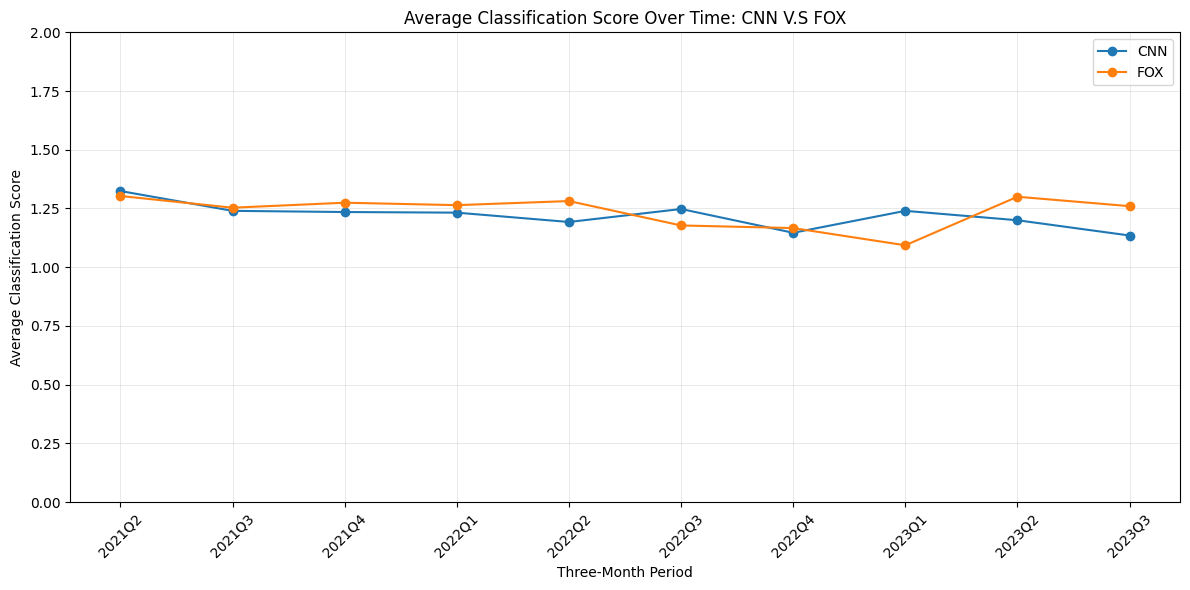

In [80]:
period_groups = cnn.groupby('period')

# graph average scores through time 
# Period labels for the X-axis
period_labels = [str(p) for p in period_groups.groups.keys()]

plt.figure(figsize=(12, 6))
# Set the y-axis to range from 0 to 2
plt.ylim(0, 2)
plt.plot(period_labels, CNN_avg_scores, marker='o', linestyle='-', label='CNN')
plt.plot(period_labels, FOX_avg_scores, marker='o', linestyle='-', label='FOX')
plt.legend()
plt.xlabel('Three-Month Period')
plt.ylabel('Average Classification Score')
plt.title('Average Classification Score Over Time: CNN V.S FOX')
plt.grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgrey', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

def BiasDistributionOverTime2(CNN_articles, FOX_articles):
    def getAverages(articles):
        # Assuming CNN_articles is your DataFrame and it's already loaded
        articles['published_date'] = pd.to_datetime(articles['published_date'])
        # Generating three-month period labels
        articles['period'] = articles['published_date'].dt.to_period('Q')
        # Splitting the DataFrame based on these periods
        period_groups = articles.groupby('period')

        # Placeholder for average classification scores
        avg_scores = []

        for name, group in period_groups:
            batch_preds = []
            for index, row in group.iterrows():
                article = row['summary']
                pred = predict_leaning(article)
                batch_preds.append(pred)
            avg_score = sum(batch_preds)/len(batch_preds)
            avg_scores.append(avg_score)

        return avg_scores


    CNN_avg_scores = getAverages(CNN_articles)
    FOX_avg_scores = getAverages(FOX_articles)
    period_groups = CNN_articles.groupby('period')

    # graph average scores through time 
    # Period labels for the X-axis
    period_labels = [str(p) for p in period_groups.groups.keys()]

    plt.figure(figsize=(12, 6))
    # Set the y-axis to range from 0 to 2
    plt.ylim(0, 2)
    plt.plot(period_labels, CNN_avg_scores, marker='o', linestyle='-', label='CNN')
    plt.plot(period_labels, FOX_avg_scores, marker='o', linestyle='-', label='FOX')
    plt.legend()
    plt.xlabel('Three-Month Period')
    plt.ylabel('Average Classification Score')
    plt.title('Average Classification Score Over Time: CNN V.S FOX')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-15 23:28:16.242889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.9/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.9/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.9/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invali

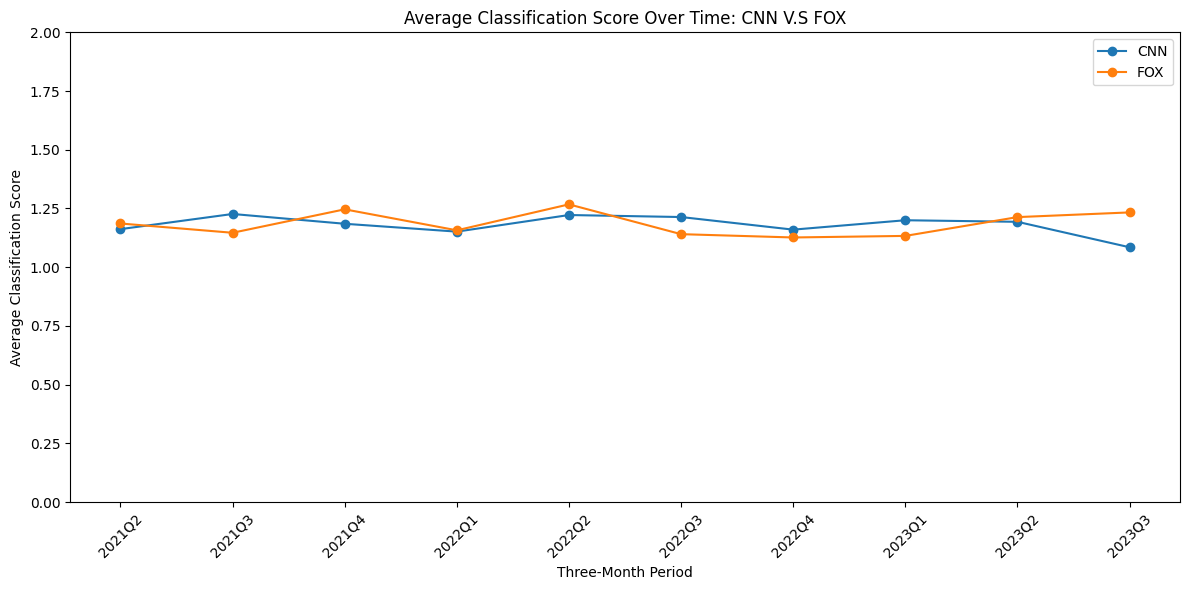

In [29]:
BiasDistributionOverTime2(cnn, fox)